In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model

2024-06-05 14:48:49.548790: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 14:48:49.577655: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-05 14:48:49.578150: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
images = []
# Load the dataset
for i in range(1, 843 + 1):
    path = f"dataset/processed/monap_{i}.png"
    img = cv2.imread(path)
    if img is None:
        # image failed to load
        continue
    else:
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) / 255
        images.append(img_rgb)
images_array = np.array(images)

In [3]:
# Splitting into 80% training and 20% test sets
train, test = train_test_split(images_array, test_size=0.2, random_state=42)

In [4]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
  def get_config(self):
    return {'latent_dim': self.latent_dim, 'shape': self.shape}


shape = test.shape[1:]
latent_dim = 128
autoencoder = Autoencoder(latent_dim, shape)

2024-06-05 14:48:51.754743: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-05 14:48:51.761301: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.fit(train, train,
                epochs=30,
                shuffle=True,
                validation_data=(test, test))

Epoch 1/30
22/22 [==============================] - 2s 84ms/step - loss: 0.0505 - val_loss: 0.0182
Epoch 2/30
22/22 [==============================] - 2s 80ms/step - loss: 0.0150 - val_loss: 0.0137
Epoch 3/30
22/22 [==============================] - 2s 80ms/step - loss: 0.0118 - val_loss: 0.0118
Epoch 4/30
22/22 [==============================] - 2s 81ms/step - loss: 0.0107 - val_loss: 0.0108
Epoch 5/30
22/22 [==============================] - 2s 81ms/step - loss: 0.0100 - val_loss: 0.0103
Epoch 6/30
22/22 [==============================] - 2s 81ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 7/30
22/22 [==============================] - 2s 80ms/step - loss: 0.0091 - val_loss: 0.0094
Epoch 8/30
22/22 [==============================] - 2s 80ms/step - loss: 0.0088 - val_loss: 0.0091
Epoch 9/30
22/22 [==============================] - 2s 81ms/step - loss: 0.0084 - val_loss: 0.0087
Epoch 10/30
22/22 [==============================] - 2s 81ms/step - loss: 0.0079 - val_loss: 0.0081
Epoch 11/

In [7]:
encoded_imgs = autoencoder.encoder(test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

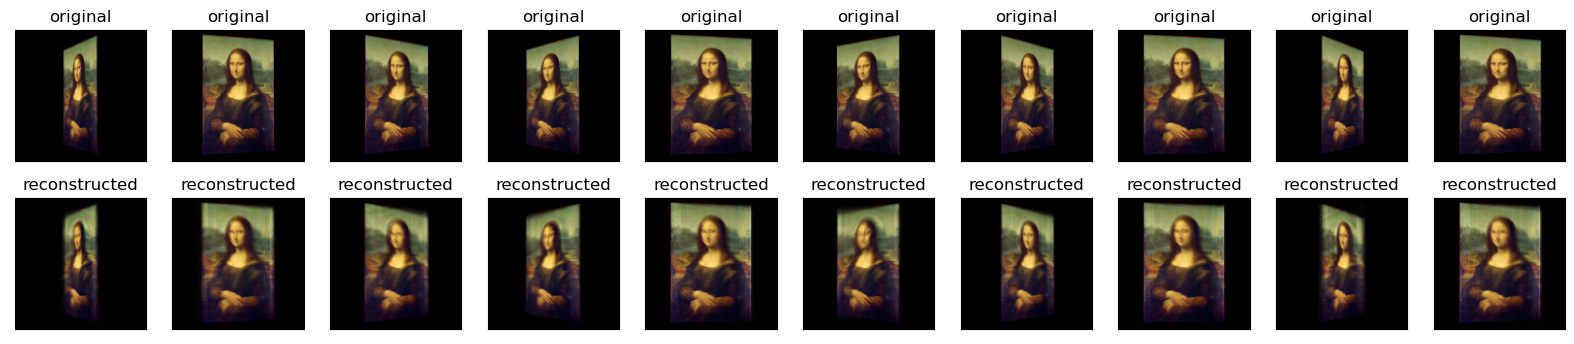

In [8]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [9]:
reconstruction_error = tf.reduce_mean(tf.square(test - decoded_imgs))

print("Reconstruction Error: ", reconstruction_error.numpy())

Reconstruction Error:  0.000704677917185799


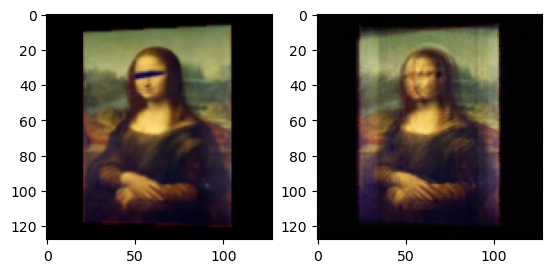

In [26]:
# lets do a test
test_img = cv2.imread(f"dataset/test/monatest_{0}.png")
test_img = np.array([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img[0])
enc_test = autoencoder.encoder(test_img).numpy()
dec_test = autoencoder.decoder(enc_test).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test[0])
plt.show()

In [27]:
# Get the reconstructed image
reconstructed_example = autoencoder(test_img)

# Compute the reconstruction error
reconstruction_error = tf.reduce_mean(tf.square(test_img - reconstructed_example))

print("Reconstruction Error: ", reconstruction_error.numpy())

Reconstruction Error:  0.004989779


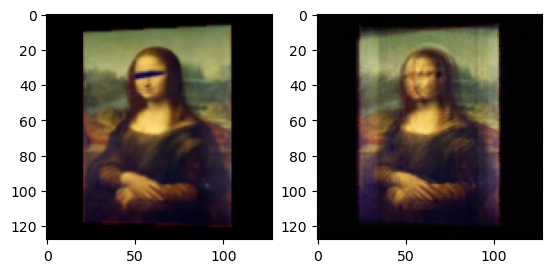

In [28]:
plt.subplot(1,2,1)
plt.imshow(test_img[0])
plt.subplot(1,2,2)
plt.imshow(reconstructed_example[0])
plt.show()

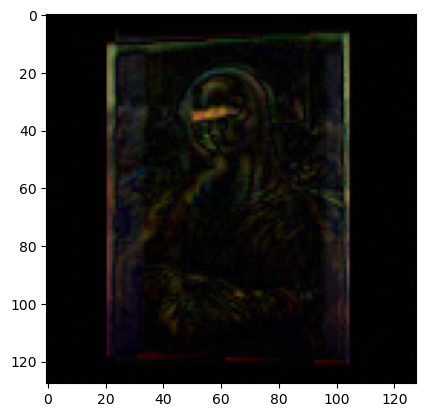

In [29]:
dif = abs(test_img[0] - reconstructed_example[0])#*255
plt.imshow(dif)
plt.show()

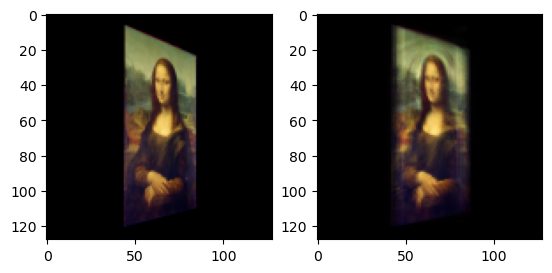

Reconstruction Error:  0.00151742479710362


In [30]:
# lets do a test
test_img = cv2.imread(f"dataset/test/monap_522.png")
test_img = np.array([cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img[0])
enc_test = autoencoder.encoder(test_img).numpy()
dec_test = autoencoder.decoder(enc_test).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test[0])
plt.show()

# Get the reconstructed image
# reconstructed_example = autoencoder(test_img)
reconstructed_example = dec_test

# Compute the reconstruction error
reconstruction_error = tf.reduce_mean(tf.square(test_img - reconstructed_example))

print("Reconstruction Error: ", reconstruction_error.numpy())

In [31]:
autoencoder.save("anomaly_detection_model")

2024-06-05 15:01:50.847204: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,49152]
	 [[{{node inputs}}]]
2024-06-05 15:01:51.053260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,49152]
	 [[{{node inputs}}]]


INFO:tensorflow:Assets written to: anomaly_detection_model/assets


INFO:tensorflow:Assets written to: anomaly_detection_model/assets


In [32]:
model2 = tf.keras.models.load_model("anomaly_detection_model")

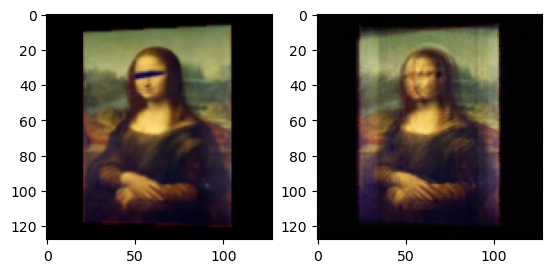

Reconstruction Error:  0.004989778917776372


In [43]:
# lets do a test
test_img_l2 = cv2.imread(f"dataset/test/monatest_{0}.png")
test_img_l2 = np.array([cv2.cvtColor(test_img_l2, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img_l2[0])
enc_test_l2 = model2.encoder(test_img_l2).numpy()
dec_test_l2 = model2.decoder(enc_test_l2).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test_l2[0])
plt.show()

# Get the reconstructed image
reconstructed_example_l2 = dec_test_l2

# Compute the reconstruction error
reconstruction_error_l2 = tf.reduce_mean(tf.square(test_img_l2 - reconstructed_example_l2))

print("Reconstruction Error: ", reconstruction_error_l2.numpy())

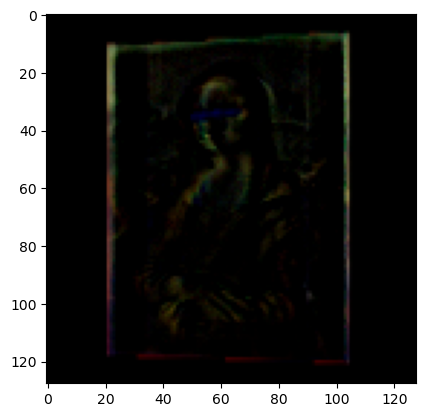

In [44]:
dif = test_img_l2[0] - reconstructed_example_l2[0]
plt.imshow(dif)
plt.show()

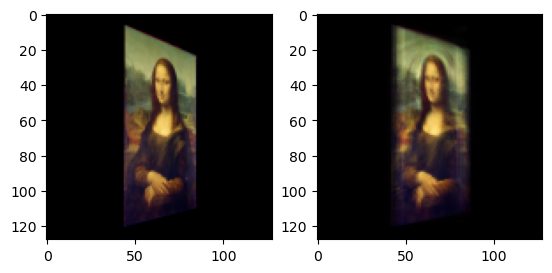

Reconstruction Error:  0.00151742479710362


In [45]:
# lets do a test
test_img_l2 = cv2.imread(f"dataset/test/monap_522.png")
test_img_l2 = np.array([cv2.cvtColor(test_img_l2, cv2.COLOR_BGR2RGB) / 255])
plt.subplot(1,2,1)
plt.imshow(test_img_l2[0])
enc_test_l2 = model2.encoder(test_img_l2).numpy()
dec_test_l2 = model2.decoder(enc_test_l2).numpy()
plt.subplot(1,2,2)
plt.imshow(dec_test_l2[0])
plt.show()

# Get the reconstructed image
reconstructed_example_l2 = dec_test_l2

# Compute the reconstruction error
reconstruction_error_l2 = tf.reduce_mean(tf.square(test_img_l2 - reconstructed_example_l2))

print("Reconstruction Error: ", reconstruction_error_l2.numpy())